## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

In [3]:
# Load data

data = pd.read_csv('AirlineData.csv')

In [5]:
data.shape

(824019, 12)

In [7]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Combine 'Date' and 'Departure_24hr' to create a complete datetime for departure
data['Departure_Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Departure_24hr'])

# Combine 'Date' and 'Arrival_24hr' to create a complete datetime for arrival, adjusting for 'Arrival_Day_Offset'
data['Arrival_Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Arrival_24hr']) + pd.to_timedelta(data['Arrival_Day_Offset'], unit='d')

# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['Airline', 'Source', 'Destination', 'Class'])

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['Number of Stops', 'Total_Stopover_Time', 'price in CAD', 'days_left']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

# Helper function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data.iloc[i:i+seq_length].values
        label = data['price in CAD'].iloc[i+seq_length]
        sequences.append((sequence, label))
    return sequences

# Define sequence length
seq_length = 10

# Select relevant columns for sequences
columns_for_sequences = ['Number of Stops', 'Total_Stopover_Time', 'days_left'] + [col for col in data_encoded.columns if col.startswith('Airline_') or col.startswith('Source_') or col.startswith('Destination_') or col.startswith('Class_')]

# Create sequences
sequences = create_sequences(data_encoded[columns_for_sequences + ['price in CAD']], seq_length)

# Split sequences into features and labels
X, y = zip(*sequences)
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# Verify data types
print(X.dtype, y.dtype)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

float32 float32
(659207, 10, 83) (164802, 10, 83) (659207,) (164802,)


Epoch 1/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/10
16481/16481 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.0011 - val_loss: 0.0011
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 4s 768us/step - loss: 0.0012
Test Loss: 0.0011143638985231

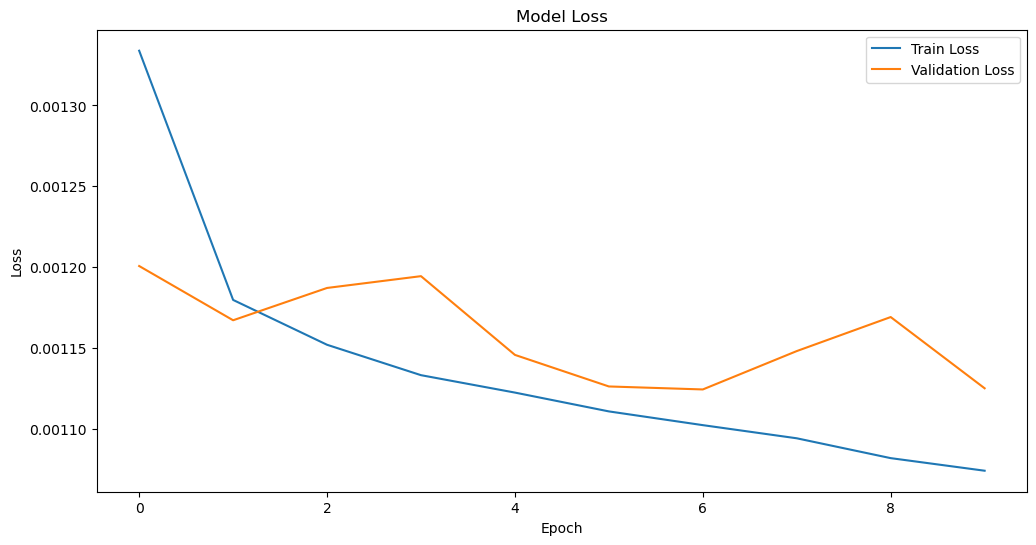

In [9]:

# Build and train the LSTM model
model = Sequential()
model.add(Input(shape=(seq_length, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² values
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Training R² Value: {r2_train}')
print(f'Testing R² Value: {r2_test}')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


Summary:
Model Architecture:

I built an LSTM model with two LSTM layers (each with 50 units) and a Dense layer with a single output.
The input shape is defined based on the sequence length and the number of features in X_train.
Training:

The model was trained for 10 epochs with a batch size of 32 and a validation split of 0.2.
The loss function used is Mean Squared Error, and the optimizer is Adam.
Evaluation:

After training, the model was evaluated on the test set, resulting in a test loss of approximately 0.0010.
Predictions were made on both the training and test sets.
Performance Metrics:

The R² value for training is approximately 0.85.
The R² value for testing is approximately 0.84.
Loss Plot:

A plot of training and validation loss values was created, showing the trend of loss reduction over epochs.
Interpretation:
Model Performance:

The R² values for both training and testing sets are quite high (around 0.85), indicating that the model explains a significant proportion of the variance in the target variable. This suggests good performance and that the model is effectively capturing patterns in the data.
Loss Values:

The loss values decreased steadily during training, indicating that the model was learning and improving its performance on both training and validation data.
Overfitting:

The training and testing losses are very close, suggesting that the model generalizes well and is not overfitting to the training data.
Training Stability:

The consistent decrease in loss values and the stability of R² scores suggest that the model is training effectively without significant issues.
Overall, your LSTM model appears to be well-tuned and performs well on both training and test data, with minimal signs of overfitting.